# Task
In this tutorial, we will classify the MNIST dataset using a Convolutional Neural Network (CNN).

# Import libraries

Before anything, let's import some basic libraries:

In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt

# Data Preparation

Training and test set should be first loaded from the folder containing our data, as was done in the previous tutorial:

In [2]:
# Load the data:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Split the data into features and labels for each image:
Y_train = train["label"]
X_train = train.drop(labels="label",axis=1)
X_test = test

# Normalize values:
X_train = X_train/255.0
test = test/255.0

# Reshape the pixels to their original 28x28 format:
X_train, Y_train = X_train.values.reshape(-1, 28,28), Y_train.values
X_test = X_test.values.reshape(-1,28,28)

# Split into training and validation:
X_valid, Y_valid = X_train[-2000:], Y_train[-2000:]
X_train, Y_train = X_train[:-2000], Y_train[:-2000]

PyTorch provides some helper functions to load data, shuffle, and augment. Dataset and DataLoader are two of these functions.

So let's create a class that is inherited from the Dataset class. This class provides functions to gather data and also to know the number of items:

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, X, Y=None):
        super().__init__()
        self.X = X
        self.Y = Y
    
    def __getitem__(self, index):
        if self.Y is None:
            return self.X[index]
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

Next step will be to instantiate the dataset to then pass it to the DataLoader. By using the DataLoader, pytorch will manage for you all the shuffling management and loading (multi-threaded) of the data:

In [4]:
trainset = MNISTDataset(X_train, Y_train)
testset = MNISTDataset(X_test)
validset = MNISTDataset(X_valid, Y_valid)

# batch_size=how many samples per batch to load
# num_workers= how many subprocesses to use for data loading
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
validloader = DataLoader(validset, batch_size=4, shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Now pytorch will manage for you all the shuffling management and loading (multi-threaded) of your data.

Let's see some of the training samples and their labels available through trainloader:

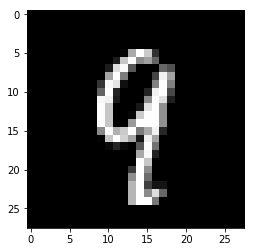

Label:  9


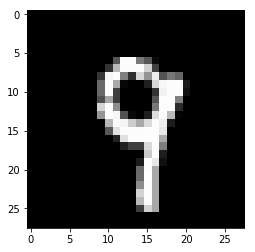

Label:  9


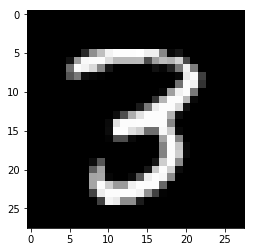

Label:  3


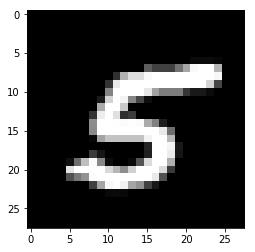

Label:  5


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for i, data in enumerate(trainloader):
    imgs, labels = data
    plt.figure()
    two_d = (np.reshape(imgs[0].numpy()*255, (28, 28))).astype(np.uint8)
    plt.imshow(two_d, cmap='gray')
    plt.show()
    print("Label: ", classes[labels[0]])
    if i >= 3:
        break

# Defining a CNN

Architecture of the convolutional neural network we will be using today, looks like below:
<img src="MNIST.png">

First, we have a convolutional layer with 10 filters of filter size 5$*$5, stride 1 and padding 0 followed by a ReLU layer. Following, is a Maxpool layer with filter size and stride set to 2. Next, is a convolutional layer with 20 fitlers of size 5$*$5, stride 1 and padding 0 followed by a ReLU layer. After that, is a Maxpool layer with size and stride set to 2. Last, we have a Fully connected layer with 50 output neurons followed by a ReLU layer, followed by a fully connected layer with 10 output neurons.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) # stride=1, number of filters=10, filter size=5
        self.pool = nn.MaxPool2d(2,2) # stride=2, filter size=2
        self.conv2 = nn.Conv2d(10, 20, 5) #stride=1, number of filters=20, filter size=5 
        self.fc1 = nn.Linear(20*4*4, 50) # fully connected layer with input size 4x4x20 and output size 50
        self.fc2 = nn.Linear(50, 10) # fully connected layer with input size 50 and output size 10 
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.float()
        a1 = self.pool(F.relu(self.conv1(x)))
        a2 = self.pool(F.relu(self.conv2(a1)))
        a3 = a2.view(-1, 20*4*4)
        a4 = F.relu(self.fc1(a3))
        a5 = self.fc2(a4)
        return a5

Let's build an instance of the model and see what it looks like:

In [7]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# Defining the Loss Function and the Optimizer

We need to define the loss function and optimizer we will use to train our network. For loss function, we will use the Cross Entropy loss which is available via the torch.nn package. For optimizer, we will use the Stochastic Gradient Descent which is available via torch.nn package. The learning rate used for training is set to 0.01: 

In [8]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate, momentum=0.5)

# Training the Network

Let's define a function for training the network:


In [9]:
def train(model, optimizer=optimizer, criterion=criterion, learning_rate=learning_rate, epochs=5):
    losses = []
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            samples, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            predictions = model(samples)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            # Print some statistics
            if i % 2000 == 1999:
                losses.append(loss.data.mean())
                print('epoch[%d], mini-batch[%5d] loss: %.3f' % (epoch+1, i+1, np.mean(losses)))
                total_loss = 0 

We can train our CNN model, "cnn" using the "train" function as below: 

In [10]:
train(cnn)

epoch[1], mini-batch[ 2000] loss: 1.340
epoch[1], mini-batch[ 4000] loss: 0.675
epoch[1], mini-batch[ 6000] loss: 0.469
epoch[1], mini-batch[ 8000] loss: 0.353
epoch[1], mini-batch[10000] loss: 0.291
epoch[2], mini-batch[ 2000] loss: 0.242
epoch[2], mini-batch[ 4000] loss: 0.208
epoch[2], mini-batch[ 6000] loss: 0.183
epoch[2], mini-batch[ 8000] loss: 0.184
epoch[2], mini-batch[10000] loss: 0.183
epoch[3], mini-batch[ 2000] loss: 0.166
epoch[3], mini-batch[ 4000] loss: 0.155
epoch[3], mini-batch[ 6000] loss: 0.144
epoch[3], mini-batch[ 8000] loss: 0.134
epoch[3], mini-batch[10000] loss: 0.125
epoch[4], mini-batch[ 2000] loss: 0.117
epoch[4], mini-batch[ 4000] loss: 0.111
epoch[4], mini-batch[ 6000] loss: 0.105
epoch[4], mini-batch[ 8000] loss: 0.100
epoch[4], mini-batch[10000] loss: 0.095
epoch[5], mini-batch[ 2000] loss: 0.090
epoch[5], mini-batch[ 4000] loss: 0.086
epoch[5], mini-batch[ 6000] loss: 0.083
epoch[5], mini-batch[ 8000] loss: 0.079
epoch[5], mini-batch[10000] loss: 0.096


Tip: When you train networks for deep learning, it is often useful to monitor the training progress. By plotting metrics such as loss or accuracy during training, you can learn how the training is progressing. For example, you can determine if and how quickly the network loss is decreasing, and whether the network is starting to overfit the training data. 

# Testing the Trained Network

Using the validation set, we can see the accuracy of trained CNN (cnn):

In [11]:
total = 0
corrects = 0

for data in validloader:
    images, labels = data
    outputs = cnn(images)
    _, predicted_lables = torch.max(outputs.data, 1)
    total += labels.size(0)
    corrects += (predicted_lables == labels).sum().item()

print('Accuracy on %d test images is = %d %%' % (total, 100*corrects/total))

Accuracy on 2000 test images is = 98 %


Let's look at some samples in the validation set and their predicted labels:

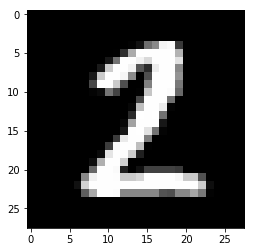

Predicted Label: [2]


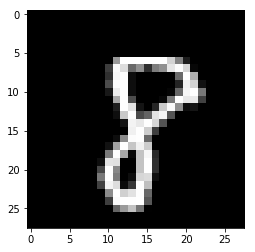

Predicted Label: [8]


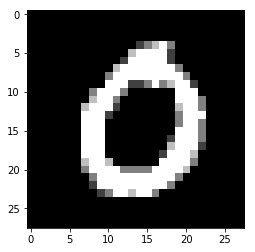

Predicted Label: [0]


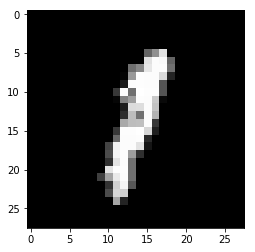

Predicted Label: [1]


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for i, data in enumerate(validloader):
    imgs, labels = data
    plt.figure()
    two_d = (np.reshape(imgs[0].numpy()*255, (28, 28))).astype(np.uint8)
    plt.imshow(two_d, cmap='gray')
    plt.show()
    outputs = cnn(imgs)
    _, predicted_label = torch.topk(outputs[0], 1)
    print('Predicted Label:', predicted_label.numpy())
    if i >= 3:
        break

# Coding:

There are other optimizer algorithms available in torch.nn package that sometimes work better than Stochastic Gradient Descent (SGD). One of these optimizers is called Adam Optimizer (Adam). Let's know train the network using the Adam optimizer:

In [13]:
# Define the Adam optimizer:
Adam_optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

# Create a new instance of CNN network to train:
# -- Your code goes here --

# Train the network using the Adam optimizer:
#-- Your code goes here --

Having done these, let's see the accuracy of the trained network on the validation set:

In [14]:
#-- Your code goes here --